In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install shap
!pip install torch==1.9.1
!pip install torchvision==0.10.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 9.5 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement torch==1.9.1 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1)
ERROR: No matching distribution found for torch==1.9.1
ERROR: Could not find a version that satisfies the requirement torchvision==0.10.1 (from versions: 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.2.2, 0.2.2.post2, 0.2.2.post3, 0.12.0, 0.13.0, 0.13.1, 0.14.0, 0.14.1, 0.15.0, 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.16.2, 0.17.0, 0.17.1)
ERROR: No matching distribution found for torchvision==0.10.1


#**ESCONDER**

In [ ]:
import zipfile
# Ruta del archivo ZIP que deseas descomprimir en Google Drive
ruta_zip = '/content/drive/MyDrive/PLANTAS_1/Hojasrecortadas-comprimidas.zip'  # Cambia esta ruta por la de tu archivo ZIP

# Ruta de la carpeta donde deseas extraer los archivos
ruta_destino = '/content/descomprimido/'  # Cambia esta ruta según tus preferencias

# Descomprimir el archivo ZIP
with zipfile.ZipFile(ruta_zip, 'r') as archivo_zip:
    archivo_zip.extractall(ruta_destino)

In [6]:
import torch
import torchvision.transforms as transforms
from torchvision.models import inception_v3, Inception_V3_Weights
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

from torchvision.transforms import Lambda
import PIL.Image as Image

# Configuración del dispositivo para usar CUDA si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import PIL.Image as Image


# Definición de transformaciones para las imágenes, incluyendo la eliminación de transparencia
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Función para cargar datos
def load_data(train_directory, test_directory):
    datasets = {
        "train": ImageFolder(root=train_directory, transform=transform),
        "test": ImageFolder(root=test_directory, transform=transform)
    }
    dataloaders = {
        x: DataLoader(datasets[x], batch_size=32, shuffle=True) for x in ['train', 'test']
    }
    return dataloaders


# Cargar y preparar el modelo InceptionV3
def prepare_model(num_classes):
    weights = Inception_V3_Weights.IMAGENET1K_V1
    model = inception_v3(weights=weights, aux_logits=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, num_classes)
    return model.to(device)

# Entrenamiento del modelo

def train_and_evaluate_model(model, dataloaders, epochs=5):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Listas para guardar los valores de pérdida y precisión
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = total = 0

        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            if isinstance(outputs, tuple):  # Si hay salidas auxiliares, usa solo la principal
                outputs = outputs[0]
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(dataloaders['train']))
        train_accuracies.append(100 * correct / total)

        # Evaluación
        model.eval()
        test_loss = 0.0
        correct = total = 0
        with torch.no_grad():
            for inputs, labels in dataloaders['test']:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                if isinstance(outputs, tuple):  # Si hay salidas auxiliares, usa solo la principal
                    outputs = outputs[0]
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_losses.append(test_loss / len(dataloaders['test']))
        test_accuracies.append(100 * correct / total)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, '
              f'Train Accuracy: {train_accuracies[-1]:.2f}%, Test Accuracy: {test_accuracies[-1]:.2f}%')

    return train_losses, test_losses, train_accuracies, test_accuracies

    # Gráfica de pérdidas
# Directorios de entrenamiento y validación (actualiza estas rutas según tu configuración)
# Directorios de entrenamiento y validación
train_directory = '/content/drive/MyDrive/papertaro/Hojasrecortadas/Train'
test_directory = '/content/drive/MyDrive/papertaro/Hojasrecortadas/Test'


# Cargar datos de entrenamiento y validación
dataloaders = load_data(train_directory, test_directory)

# Definir el número de clases
num_classes = 3  # Ajusta esto según tu conjunto de datos específico

# Preparar y entrenar el modelo
model = prepare_model(num_classes)


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 191MB/s] 


###ESCONDER

In [ ]:
    # Gráfica de pérdidas
# Directorios de entrenamiento y validación (actualiza estas rutas según tu configuración)
# Directorios de entrenamiento y validación
train_directory = '/content/drive/MyDrive/papertaro/Hojasrecortadas/Train'
test_directory = '/content/drive/MyDrive/papertaro/Hojasrecortadas/Test'


# Cargar datos de entrenamiento y validación
dataloaders = load_data(train_directory, test_directory)

# Definir el número de clases
num_classes = 3  # Ajusta esto según tu conjunto de datos específico

# Preparar y entrenar el modelo
model = prepare_model(num_classes)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 84.5MB/s] 


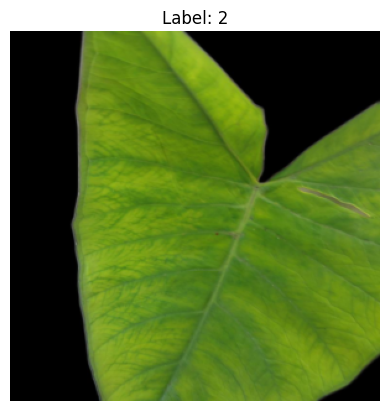

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extrae un batch de imágenes y etiquetas del DataLoader de entrenamiento
images, labels = next(iter(dataloaders['train']))


# Selecciona la primera imagen del batch
image = images[4]

# Convierte el tensor de la imagen a un formato adecuado para matplotlib
# Primero, mueve el canal de color al final
# Segundo, convierte el tensor a un array de numpy
# Tercero, asegúrate de que los valores estén en el rango [0, 1] para visualizar correctamente
image = image.numpy().transpose((1, 2, 0))  # Cambia C, H, W a H, W, C
# Si aplicaste normalización en tus transformaciones, debes desnormalizar aquí
#image = (image - image.min()) / (image.max() - image.min())  # Normalización simple para visualización

# Muestra la imagen
plt.imshow(image)
plt.title(f'Label: {labels[0]}')  # Muestra la etiqueta de la imagen
plt.axis('off')  # Oculta los ejes
plt.show()


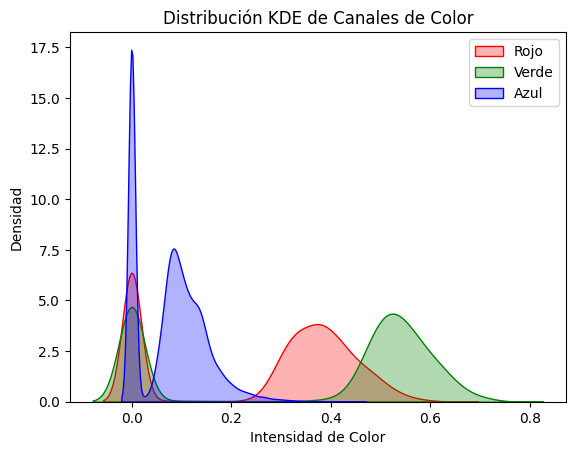

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Asumiendo que 'image' es la imagen cargada y preprocesada (sin normalización aplicada aquí)

# Extraer canales de color
r = image[:, :, 0].flatten()  # Canal Rojo
g = image[:, :, 1].flatten()  # Canal Verde
b = image[:, :, 2].flatten()  # Canal Azul

# Configurar la visualización de KDE (Estimación de Densidad Kernel) para cada canal
sns.kdeplot(r, color='red', fill=True, alpha=0.3, label='Rojo')
sns.kdeplot(g, color='green', fill=True, alpha=0.3, label='Verde')
sns.kdeplot(b, color='blue', fill=True, alpha=0.3, label='Azul')

# Ajustes del gráfico
plt.title('Distribución KDE de Canales de Color')
plt.xlabel('Intensidad de Color')
plt.ylabel('Densidad')
plt.legend()
plt.show()


#JALAR AQUI

In [3]:
import torch
import torchvision.transforms as transforms
from torchvision.models import inception_v3, Inception_V3_Weights
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

from torchvision.transforms import Lambda
import PIL.Image as Image

# Configuración del dispositivo para usar CUDA si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import PIL.Image as Image


# Definición de transformaciones para las imágenes, incluyendo la eliminación de transparencia
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Función para cargar datos
def load_data(train_directory, test_directory):
    datasets = {
        "train": ImageFolder(root=train_directory, transform=transform),
        "test": ImageFolder(root=test_directory, transform=transform)
    }
    dataloaders = {
        x: DataLoader(datasets[x], batch_size=32, shuffle=True) for x in ['train', 'test']
    }
    return dataloaders


# Cargar y preparar el modelo InceptionV3
def prepare_model(num_classes):
    weights = Inception_V3_Weights.IMAGENET1K_V1
    model = inception_v3(weights=weights, aux_logits=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, num_classes)
    return model.to(device)



In [25]:
import torch
import torchvision.transforms as transforms
from torchvision.models import inception_v3, Inception_V3_Weights
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import PIL.Image as Image

# Configuración del dispositivo para usar CUDA si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Definición de transformaciones para las imágenes
def preprocessing_pipeline():
    # The transformations will include random adjustments to brightness,
    # contrast, saturation, and potentially adding noise.
    # These can help the model learn to ignore the background.
    return transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

# Use this transform as a preprocessing step to zero out the background
def remove_background(image):
    # Assuming the background is black, which corresponds to 0 after normalization
    # This lambda function will set the near-black background pixels to absolute black
    return transforms.functional.adjust_gamma(image, gamma=2.2, gain=1)

# Función para cargar datos
def load_data(train_directory, test_directory):
    transform = preprocessing_pipeline()
    datasets = {
        "train": ImageFolder(root=train_directory, transform=transform),
        "test": ImageFolder(root=test_directory, transform=transform)
    }
    dataloaders = {
        x: DataLoader(datasets[x], batch_size=32, shuffle=True) for x in ['train', 'test']
    }
    return dataloaders

# Add the remove_background function to the transform pipeline
transform.transforms.insert(0, Lambda(remove_background))

# Cargar y preparar el modelo InceptionV3
def prepare_model(num_classes):
    weights = Inception_V3_Weights.IMAGENET1K_V1
    model = inception_v3(weights=weights, aux_logits=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, num_classes)
    return model.to(device)


In [40]:
import torch
from torchvision import transforms
from torchvision.models import inception_v3, Inception_V3_Weights
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.transforms import Lambda
import PIL.Image as Image

# Configuración del dispositivo para usar CUDA si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Definición de transformaciones para las imágenes
def preprocessing_pipeline():
    # The transformations will include random adjustments to brightness,
    # contrast, saturation, and potentially adding noise.
    # These can help the model learn to ignore the background.
    return transforms.Compose([
        Lambda(remove_background),
        transforms.Resize((299, 299)),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

# Use this transform as a preprocessing step to zero out the background
def remove_background(pil_img):
    # Convert PIL image to numpy array
    np_img = np.array(pil_img)

    # Set a threshold below which everything is considered background and zeroed out
    threshold = 10  # You may need to adjust this threshold
    mask = (np_img > threshold).astype(np_img.dtype)  # Create a mask for non-background
    np_img *= mask  # Apply mask to image

    # Convert back to PIL image
    return Image.fromarray(np_img)

# Función para cargar datos
def load_data(train_directory, test_directory):
    # Applying the preprocessing pipeline to the datasets
    train_transform = preprocessing_pipeline()
    test_transform = preprocessing_pipeline()  # Usually, you'd have less augmentation for test data

    datasets = {
        "train": ImageFolder(root=train_directory, transform=train_transform),
        "test": ImageFolder(root=test_directory, transform=test_transform)  # Use test_transform if it's different
    }
    dataloaders = {
        x: DataLoader(datasets[x], batch_size=32, shuffle=True) for x in ['train', 'test']
    }
    return dataloaders

# Cargar y preparar el modelo InceptionV3
def prepare_model(num_classes):
    weights = Inception_V3_Weights.IMAGENET1K_V1
    model = inception_v3(weights=weights, aux_logits=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, num_classes)
    return model.to(device)

# Rest of your training code...


In [14]:
"""import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import classification_report
import numpy as np

def train_and_evaluate_model(model, dataloaders, epochs=5, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Lists to store performance metrics
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    # Variables to collect predicted and true labels for computing performance metrics
    y_true = []
    y_pred = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = total = 0

        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs, aux_outputs = model(inputs)
            loss1 = criterion(outputs, labels)
            loss2 = criterion(aux_outputs, labels)
            loss = loss1 + 0.4*loss2
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(dataloaders['train']))
        train_accuracies.append(100 * correct / total)

        # Evaluation phase
        model.eval()
        test_loss = 0.0
        correct = total = 0
        with torch.no_grad():
            for inputs, labels in dataloaders['test']:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Append data for metrics
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        test_losses.append(test_loss / len(dataloaders['test']))
        test_accuracies.append(100 * correct / total)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, '
              f'Train Accuracy: {train_accuracies[-1]:.2f}%, Test Accuracy: {test_accuracies[-1]:.2f}%')

    # Compute performance metrics
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    print(classification_report(y_true, y_pred, target_names=['Class 1', 'Class 2', 'Class 3']))

    return train_losses, test_losses, train_accuracies, test_accuracies, y_true, y_pred



In [26]:
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import classification_report
import numpy as np

def train_and_evaluate_model(model, dataloaders, epochs=5, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Lists to store performance metrics
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    # Variables to collect predicted and true labels for computing performance metrics
    y_true_test = []  # To collect true labels from the test set
    y_pred_test = []  # To collect predicted labels from the test set

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = total = 0

        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Handle models with auxiliary outputs, like Inception
            outputs = model(inputs)
            if isinstance(outputs, tuple):
                loss = sum((criterion(o, labels) for o in outputs))
                outputs = outputs[0]  # Main output for accuracy calculation
            else:
                loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(dataloaders['train']))
        train_accuracies.append(100 * correct / total)

        # Evaluation phase
        model.eval()
        test_loss = 0.0
        correct = total = 0
        with torch.no_grad():
            for inputs, labels in dataloaders['test']:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                if isinstance(outputs, tuple):
                    loss = sum((criterion(o, labels) for o in outputs))
                    outputs = outputs[0]  # Main output for accuracy calculation
                else:
                    loss = criterion(outputs, labels)
                test_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Append data for metrics
                y_true_test.extend(labels.cpu().numpy())
                y_pred_test.extend(predicted.cpu().numpy())

        test_losses.append(test_loss / len(dataloaders['test']))
        test_accuracies.append(100 * correct / total)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, '
              f'Train Accuracy: {train_accuracies[-1]:.2f}%, Test Accuracy: {test_accuracies[-1]:.2f}%')

    # Compute performance metrics at the end of training
    y_true_test = np.array(y_true_test)
    y_pred_test = np.array(y_pred_test)
    print(classification_report(y_true_test, y_pred_test, target_names=['Class 1', 'Class 2', 'Class 3']))

    return train_losses, test_losses, train_accuracies, test_accuracies, y_true_test, y_pred_test


In [21]:
train_directory = '/content/drive/MyDrive/papertaro/Hojasrecortadas/Train'
test_directory = '/content/drive/MyDrive/papertaro/Hojasrecortadas/Test'




In [22]:
# Remember to replace '/path/to/train' and '/path/to/test' with your actual dataset paths
dataloaders = load_data('/content/drive/MyDrive/papertaro/Hojasrecortadas/Train', '/content/drive/MyDrive/papertaro/Hojasrecortadas/Test')

# Adjust num_classes to match your dataset
model = prepare_model(num_classes=3)

In [41]:
# Remember to replace '/path/to/train' and '/path/to/test' with your actual dataset paths
dataloaders = load_data('/content/drive/MyDrive/papertaro/Hojasrecortadas/Train', '/content/drive/MyDrive/papertaro/Hojasrecortadas/Test')

# Adjust num_classes to match your dataset
model = prepare_model(num_classes=3)

# Train and evaluate the model
train_losses, test_losses, train_accuracies, test_accuracies, y_true, y_pred = train_and_evaluate_model(model, dataloaders, epochs=2)


Epoch 1/2, Train Loss: 0.4838, Test Loss: 0.8711, Train Accuracy: 92.79%, Test Accuracy: 72.52%
Epoch 2/2, Train Loss: 0.3212, Test Loss: 0.1366, Train Accuracy: 95.27%, Test Accuracy: 93.77%
              precision    recall  f1-score   support

     Class 1       0.59      1.00      0.74       164
     Class 2       1.00      0.52      0.68       198
     Class 3       0.98      0.93      0.96       344

    accuracy                           0.83       706
   macro avg       0.86      0.82      0.79       706
weighted avg       0.90      0.83      0.83       706



In [ ]:
# Ejecutar entrenamiento y evaluación
"""train_losses, test_losses, train_accuracies, test_accuracies = train_and_evaluate_model(model, dataloaders, epochs=100)


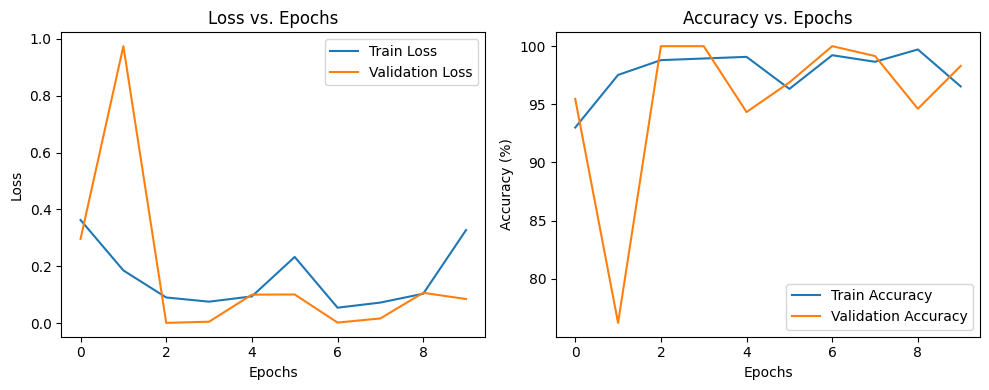

In [28]:
import matplotlib.pyplot as plt


# Graficar pérdidas
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


# Graficar precisión
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()

##salvar modelo para no volver a entrenar

In [100]:
import torch
import pickle

# Save the model state
model_path = "/content/drive/MyDrive/papertaro/model.pth"
torch.save(model.state_dict(), model_path)

# Save training losses, accuracies, and predictions
data = {
    'train_losses': train_losses,
    'test_losses': test_losses,
    'train_accuracies': train_accuracies,
    'test_accuracies': test_accuracies,
    'y_true': y_true,
    'y_pred': y_pred
}
with open("/content/drive/MyDrive/papertaro/training_data.pkl", "wb") as f:
    pickle.dump(data, f)


###cargar el modelo

In [9]:
import pickle
# Load the model state
model = prepare_model(num_classes=3)  # Ensure to initialize the model first
model.load_state_dict(torch.load("/content/drive/MyDrive/papertaro/model.pth"))
model.eval()  # Set the model to evaluation mode

# Load training losses, accuracies, and predictions
with open("/content/drive/MyDrive/papertaro/training_data.pkl", "rb") as f:
    data = pickle.load(f)

train_losses = data['train_losses']
test_losses = data['test_losses']
train_accuracies = data['train_accuracies']
test_accuracies = data['test_accuracies']
y_true = data['y_true']
y_pred = data['y_pred']


##ROC curve

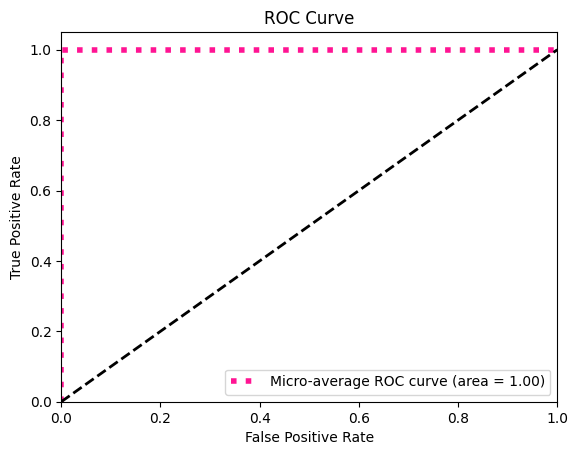

In [10]:
import torch
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

# Assuming you have a DataLoader for your test dataset: dataloaders['test']
# And your model is already trained: model

# Prepare model for evaluation
model.eval()

# Collect all the outputs and labels here
all_outputs = []
all_labels = []

with torch.no_grad():
    for images, labels in dataloaders['test']:
        images = images.to(device)
        outputs = model(images)
        # Apply softmax to calculate probabilities
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        all_outputs.append(probabilities.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all outputs and labels to get a complete set
y_score = np.concatenate(all_outputs)
y_true = np.concatenate(all_labels)

# Assuming you have 3 classes, you need to binarize the labels for ROC analysis
y_true = label_binarize(y_true, classes=[0, 1, 2])
n_classes = y_true.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Optionally, plot the ROC curves
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


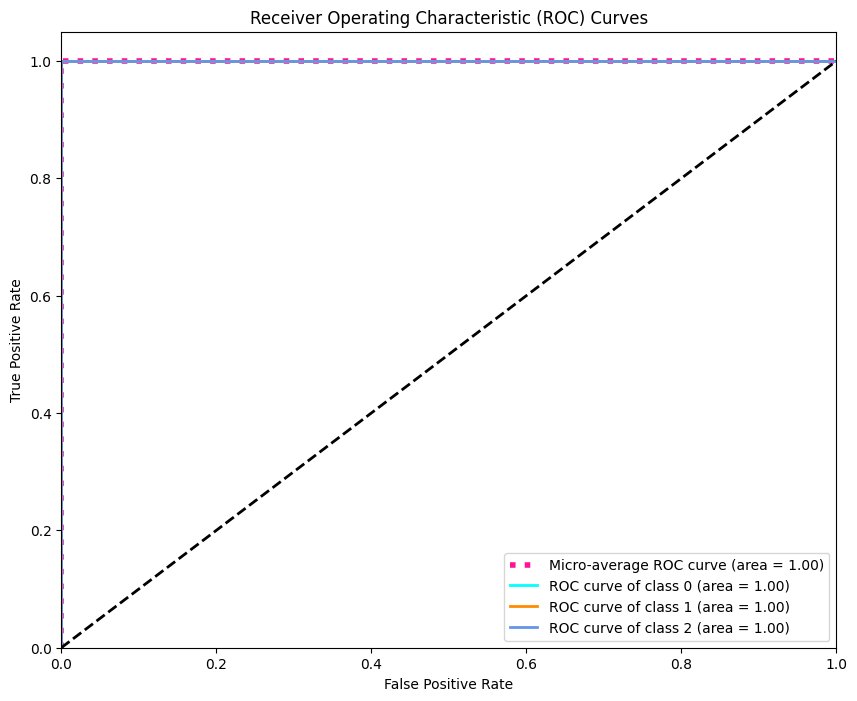

In [11]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle

# Assuming you have 3 classes
n_classes = 3
y_test = label_binarize(y_true, classes=[0, 1, 2])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr["micro"], tpr["micro"], label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]), color='deeppink', linestyle=':', linewidth=4)
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()


Length of y_true_test: 353, Length of y_pred_test: 353


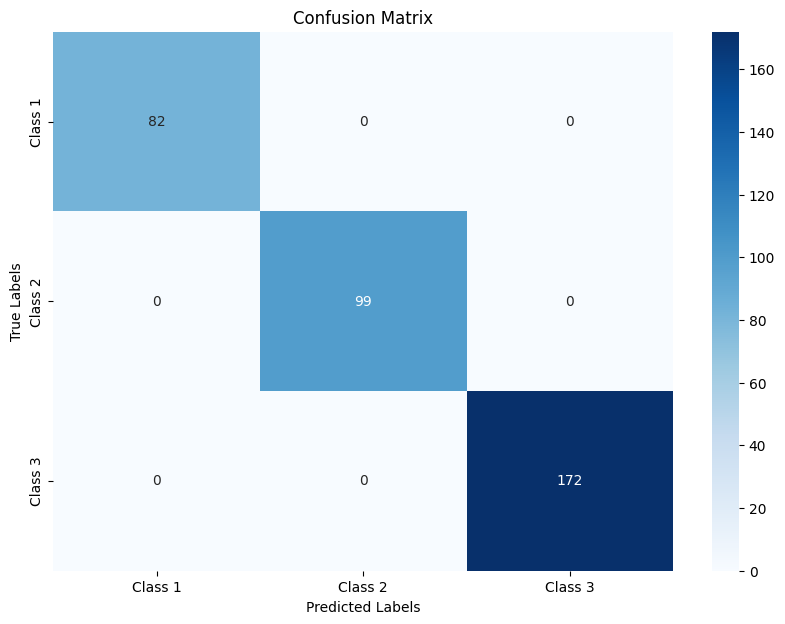

In [103]:
def evaluate_model(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

# Use the corrected evaluation function to obtain y_true and y_pred
y_true_test, y_pred_test = evaluate_model(model, dataloaders['test'], device)

# Verify the lengths match
print(f"Length of y_true_test: {len(y_true_test)}, Length of y_pred_test: {len(y_pred_test)}")

# Assuming the lengths match, plot the confusion matrix
cm = confusion_matrix(y_true_test, y_pred_test)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 1', 'Class 2', 'Class 3'], yticklabels=['Class 1', 'Class 2', 'Class 3'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


##metricas

In [104]:
from sklearn.metrics import classification_report

# Assuming y_true and y_pred are available
print(classification_report(y_true_test, y_pred_test, target_names=['Class 1', 'Class 2', 'Class 3']))


              precision    recall  f1-score   support

     Class 1       1.00      1.00      1.00        82
     Class 2       1.00      1.00      1.00        99
     Class 3       1.00      1.00      1.00       172

    accuracy                           1.00       353
   macro avg       1.00      1.00      1.00       353
weighted avg       1.00      1.00      1.00       353



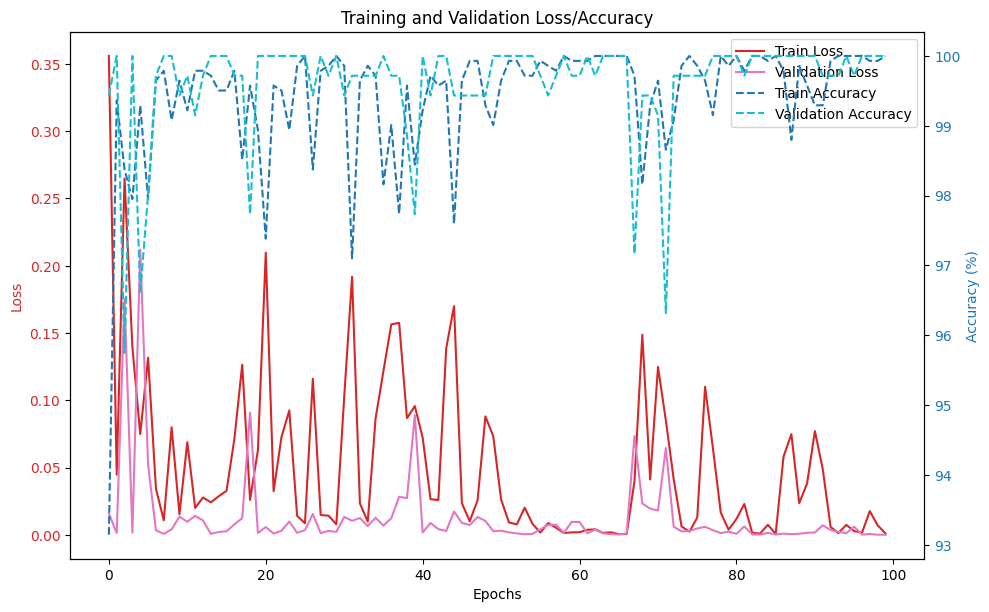

In [105]:
import matplotlib.pyplot as plt

# Suponiendo que ya tienes train_losses, test_losses, train_accuracies, test_accuracies
# gracias a la ejecución de train_and_evaluate_model(model, dataloaders, epochs=5)

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
lns1 = ax1.plot(train_losses, label='Train Loss', color=color)
lns2 = ax1.plot(test_losses, label='Validation Loss', color='tab:pink')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # Instanciar un segundo eje Y que comparte el mismo eje X
color = 'tab:blue'
ax2.set_ylabel('Accuracy (%)', color=color)  # we already handled the x-label with ax1
lns3 = ax2.plot(train_accuracies, label='Train Accuracy', color=color, linestyle='--')
lns4 = ax2.plot(test_accuracies, label='Validation Accuracy', color='tab:cyan', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

# Combinar leyendas de los dos ejes
lns = lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

fig.tight_layout()  # para asegurar un buen layout
plt.title('Training and Validation Loss/Accuracy')
plt.show()


#shaps

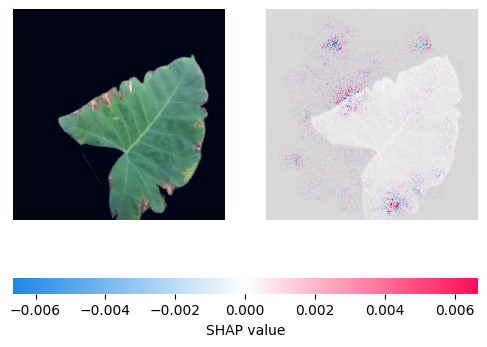

The predicted class label is: L


In [42]:
import numpy as np
import shap
import matplotlib.pyplot as plt
import torch

# Assuming 'device', 'model', and 'dataloaders' are already defined

# Setting up SHAP explainer
background, _ = next(iter(dataloaders['train']))
background = background.to(device)
e = shap.GradientExplainer(model, background, local_smoothing=0.1)

# Getting a batch of test images
test_images, test_labels = next(iter(dataloaders['test']))
test_images = test_images.to(device)

# Compute SHAP values for the first image
shap_values = e.shap_values(test_images[:1])

# Predict class for the first image
output = model(test_images[:1])
predicted_class = output.max(1)[1].item()

# Ensure the predicted class is within the bounds of available SHAP values
if predicted_class < shap_values.shape[1]:
    shap_values_for_plotting = shap_values[0, predicted_class, :, :, :]

    # Preparing the image for plotting
    test_image_for_plotting = test_images[0].cpu().numpy().transpose(1, 2, 0)
    test_image_for_plotting = (test_image_for_plotting - test_image_for_plotting.min()) / (test_image_for_plotting.max() - test_image_for_plotting.min())

    # SHAP Image Plot
    shap.image_plot(shap_values_for_plotting[np.newaxis, :], test_image_for_plotting[np.newaxis, :])
    # Display predicted class
    class_labels = {0: "H", 1: "L", 2: 'M'}  # Adjust according to your dataset
    print("The predicted class label is:", class_labels[predicted_class])
else:
    print(f"Predicted class {predicted_class} is out of bounds. SHAP values are not available for this class.")


<Figure size 640x480 with 0 Axes>

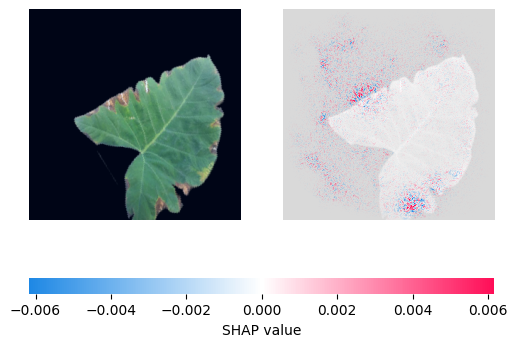

The predicted class label for image 0 is: L


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

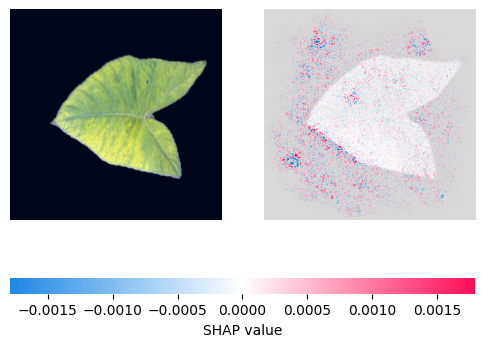

The predicted class label for image 1 is: M


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

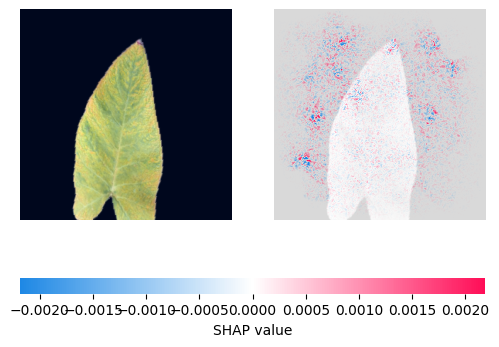

The predicted class label for image 2 is: M


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

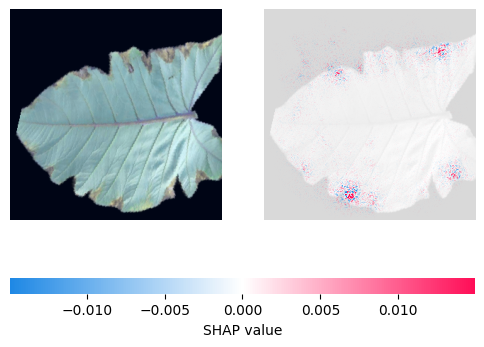

The predicted class label for image 3 is: L


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

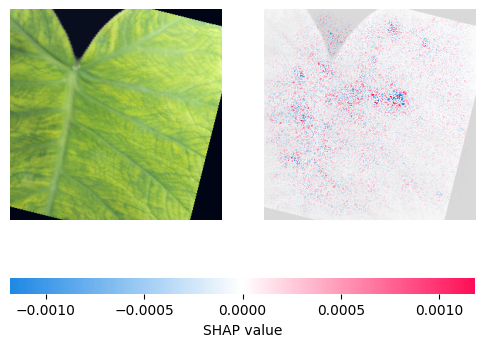

The predicted class label for image 4 is: M


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

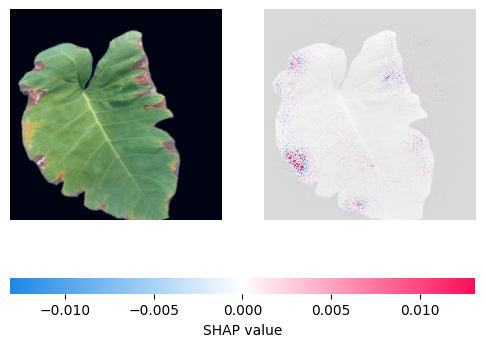

The predicted class label for image 5 is: L


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

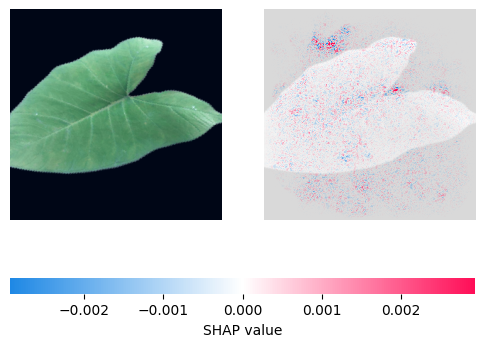

The predicted class label for image 6 is: H


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

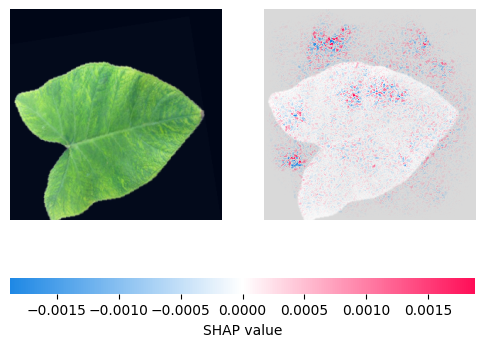

The predicted class label for image 7 is: M


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

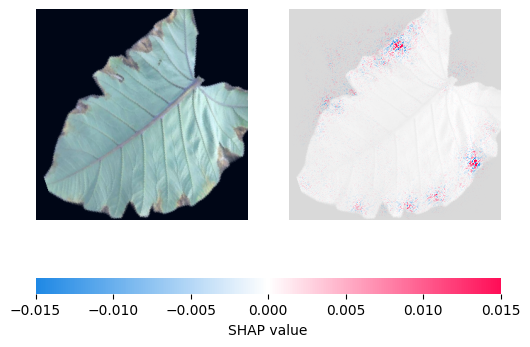

In [ ]:
for i in range(50):
    # Compute SHAP values for the i-th image
    shap_values = e.shap_values(test_images[i:i+1])

    # Predict class for the i-th image
    output = model(test_images[i:i+1])
    predicted_class = output.max(1)[1].item()

    # Ensure the predicted class is within the bounds of available SHAP values
    if predicted_class < shap_values.shape[1]:
        shap_values_for_plotting = shap_values[0, predicted_class, :, :, :]

        # Preparing the image for plotting
        test_image_for_plotting = test_images[i].cpu().numpy().transpose(1, 2, 0)
        test_image_for_plotting = (test_image_for_plotting - test_image_for_plotting.min()) / (test_image_for_plotting.max() - test_image_for_plotting.min())

        # Plot SHAP values
        plt.figure()
        shap.image_plot(shap_values_for_plotting[np.newaxis, :], test_image_for_plotting[np.newaxis, :])

        # Optionally save the figure to a file
        # plt.savefig(f"shap_output_{i}.png")

        # Display predicted class
        print(f"The predicted class label for image {i} is:", class_labels[predicted_class])
    else:
        print(f"Predicted class {predicted_class} for image {i} is out of bounds. SHAP values are not available for this class.")

    # Clear the current figure after plotting to avoid overlap
    plt.clf()


In [14]:
shap_values.shape

(1, 3, 299, 299, 3)

In [106]:
import numpy as np
import shap
import matplotlib.pyplot as plt

# Setting up SHAP explainer
background, _ = next(iter(dataloaders['train']))
background = background.to(device)
e = shap.GradientExplainer(model, background, local_smoothing=0.1)

# Getting a batch of test images
test_images, test_labels = next(iter(dataloaders['test']))
test_images = test_images.to(device)

# Compute SHAP values for the first image
shap_values = e.shap_values(test_images[:1])

# Predict class for the first image
output = model(test_images[:1])
predicted_class = output.max(1)[1].item()

# Ensure the predicted class is within the bounds of available SHAP values
if predicted_class < len(shap_values):
    shap_values_for_plotting = shap_values[predicted_class][0].transpose(1, 2, 0)

    # Preparing the image for plotting
    test_image_for_plotting = test_images[0].cpu().numpy().transpose(1, 2, 0)
    test_image_for_plotting = (test_image_for_plotting - test_image_for_plotting.min()) / (test_image_for_plotting.max() - test_image_for_plotting.min())

    # SHAP Image Plot
    shap.image_plot(shap_values_for_plotting[np.newaxis, :], test_image_for_plotting[np.newaxis, :])

    # Display predicted class
    class_labels = {0: "H", 1: "L", 2: 'M'}  # Define according to your dataset
    print("La etiqueta de la clase predicha es:", class_labels[predicted_class])
else:
    print(f"Predicted class {predicted_class} is out of bounds. SHAP values are not available for this class.")


Predicted class 1 is out of bounds. SHAP values are not available for this class.


In [107]:
import numpy as np
import shap
import matplotlib.pyplot as plt

# Análisis SHAP
background, _ = next(iter(dataloaders['train']))
background = background.to(device)
e = shap.GradientExplainer(model, background, local_smoothing=0.1)
test_images, test_labels = next(iter(dataloaders['test']))
test_images = test_images.to(device)
shap_values = e.shap_values(test_images[:1])
output = model(test_images[:1])
predicted_class = output.max(1)[1].item()


In [69]:
shap_values

array([[[[[ 2.03810908e-07,  1.97747397e-07, -6.70737672e-07],
          [-2.27241449e-07, -1.34226845e-07, -5.36290541e-09],
          [-1.13835754e-06,  1.85358081e-07,  4.95692336e-07],
          ...,
          [ 1.67117502e-06,  1.12743555e-06, -4.84382786e-07],
          [-2.77669747e-07,  4.83441874e-07, -3.33441719e-07],
          [-4.03825812e-07,  6.94320590e-07,  2.03431041e-07]],

         [[ 1.75669793e-08,  1.56578432e-07,  2.85042732e-07],
          [-1.44531302e-07,  3.52485337e-07, -2.59937260e-07],
          [ 8.36805524e-07, -9.90980554e-07,  1.03975639e-06],
          ...,
          [-4.50343597e-06,  1.55169164e-06, -1.30555772e-06],
          [-2.61017437e-07, -4.00864323e-08, -1.67012383e-06],
          [ 1.04569276e-06,  2.53662586e-06,  1.85387324e-07]],

         [[-3.46829619e-07, -1.81783652e-07, -2.00638712e-07],
          [-1.47807302e-06,  3.21819209e-07, -1.97819560e-07],
          [ 1.71901138e-06,  2.31732829e-07,  1.68737873e-07],
          ...,
      

In [51]:
shap_values

array([[[[[ 3.93753046e-07,  2.35866119e-06,  2.42375186e-06],
          [-4.12146429e-06,  3.95053962e-06,  2.38880558e-06],
          [-7.58930883e-06,  1.52168940e-06,  6.02959007e-06],
          ...,
          [ 8.26506999e-06,  9.23073196e-06, -2.44083552e-06],
          [ 3.16629750e-06,  1.35895651e-06, -2.33860129e-06],
          [ 9.57796695e-07, -8.91459490e-07, -2.05635329e-06]],

         [[-3.07711228e-06,  5.55638874e-06,  3.38931023e-06],
          [-1.00181664e-05,  3.32888229e-06,  4.51115352e-06],
          [-2.81668466e-05,  3.06456425e-06,  4.84449490e-06],
          ...,
          [ 4.80533331e-07,  3.73627429e-06, -6.19441060e-07],
          [-9.09083391e-08, -1.49358770e-06, -2.49843870e-06],
          [-4.19004946e-06, -1.21637126e-05, -8.28402876e-07]],

         [[-7.65515079e-06,  8.78344465e-06,  7.01016392e-06],
          [-1.06389251e-05,  1.00072863e-05, -3.69225504e-06],
          [-5.96515475e-06, -3.08944930e-06,  7.48565133e-08],
          ...,
      

In [70]:
print("Shape of SHAP values:", shap_values.shape)
print("Predicted class:", predicted_class)

if predicted_class >= len(shap_values):
    raise ValueError(f"The predicted class index {predicted_class} is out of bounds for the SHAP values array with shape {shap_values.shape}.")


Shape of SHAP values: (1, 3, 299, 299, 3)
Predicted class: 2


ValueError: The predicted class index 2 is out of bounds for the SHAP values array with shape (1, 3, 299, 299, 3).

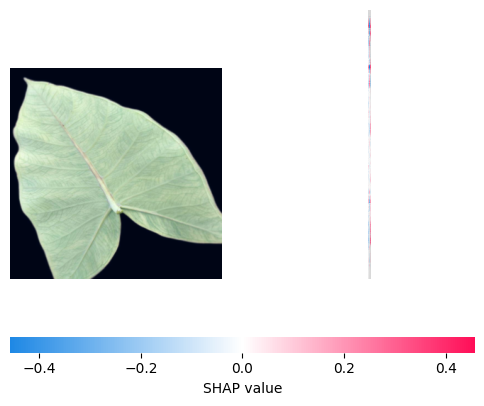

La etiqueta de la clase predicha es: M


In [108]:
shap_values_for_plotting = shap_values[0][predicted_class]  # Index into the correct dimension
shap_values_for_plotting = shap_values_for_plotting.transpose(1, 2, 0)
test_image_for_plotting = test_images[0].cpu().numpy()
test_image_for_plotting = test_image_for_plotting.transpose(1, 2, 0)
test_image_for_plotting = (test_image_for_plotting - test_image_for_plotting.min()) / (test_image_for_plotting.max() - test_image_for_plotting.min())



# SHAP Image Plot
shap.image_plot(shap_values_for_plotting[np.newaxis, :], test_image_for_plotting[np.newaxis, :])

# Para guardar la figura con alta resolución, descomenta la siguiente línea:
# plt.savefig('shap_figure.png', dpi=300)

# Mostrar la figura en pantalla
plt.show()

class_labels = {0: "H", 1: "L", 2: 'M'}  # Define según tu conjunto de datos
print("La etiqueta de la clase predicha es:", class_labels[predicted_class])



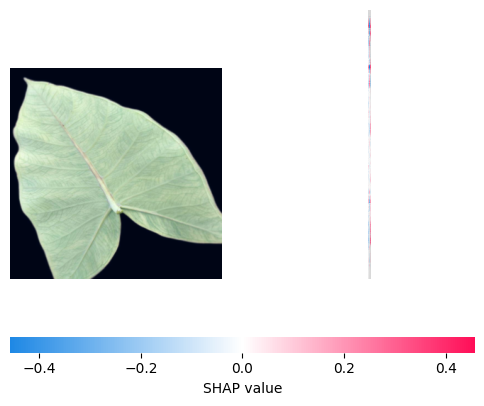

La etiqueta de la clase predicha es: M


In [109]:
test_image_for_plotting = test_images[0].cpu().numpy()
test_image_for_plotting = test_image_for_plotting.transpose(1, 2, 0)
test_image_for_plotting = (test_image_for_plotting - test_image_for_plotting.min()) / (test_image_for_plotting.max() - test_image_for_plotting.min())



# SHAP Image Plot
shap.image_plot(shap_values_for_plotting[np.newaxis, :], test_image_for_plotting[np.newaxis, :])

# Para guardar la figura con alta resolución, descomenta la siguiente línea:
# plt.savefig('shap_figure.png', dpi=300)

# Mostrar la figura en pantalla
plt.show()

class_labels = {0: "H", 1: "L", 2: 'M'}  # Define según tu conjunto de datos
print("La etiqueta de la clase predicha es:", class_labels[predicted_class])


In [110]:
shap_values_for_plotting = shap_values_for_plotting.transpose(0, 2, 1)


In [87]:
print(shap_values_for_plotting.shape)


(299, 299, 3)


<Figure size 640x480 with 0 Axes>

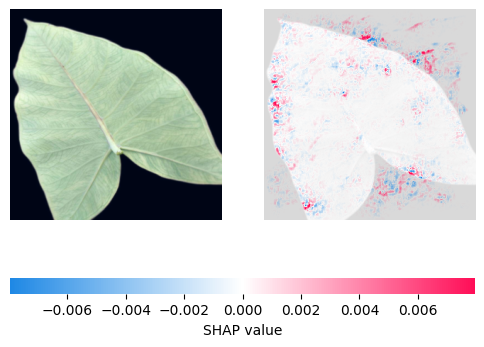

Image 1: The predicted class label is: M


<Figure size 640x480 with 0 Axes>

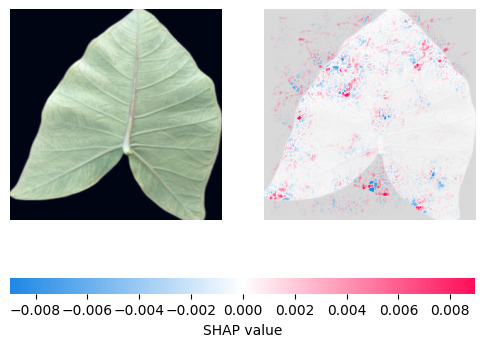

Image 2: The predicted class label is: M


<Figure size 640x480 with 0 Axes>

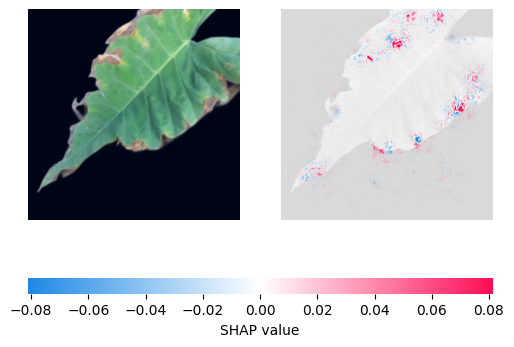

Image 3: The predicted class label is: L


<Figure size 640x480 with 0 Axes>

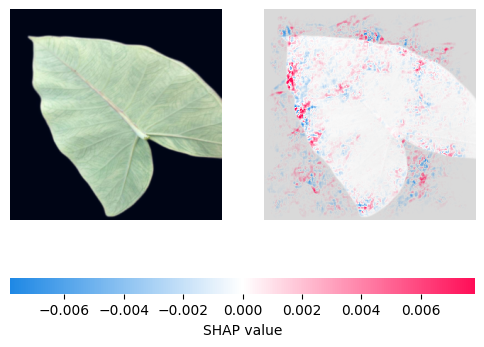

Image 4: The predicted class label is: M


<Figure size 640x480 with 0 Axes>

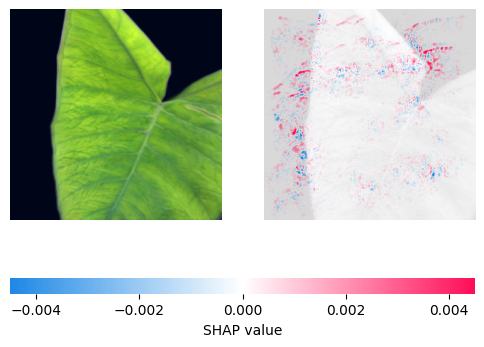

Image 5: The predicted class label is: M


<Figure size 640x480 with 0 Axes>

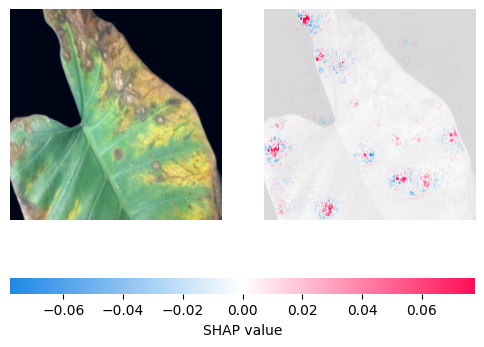

Image 6: The predicted class label is: L


<Figure size 640x480 with 0 Axes>

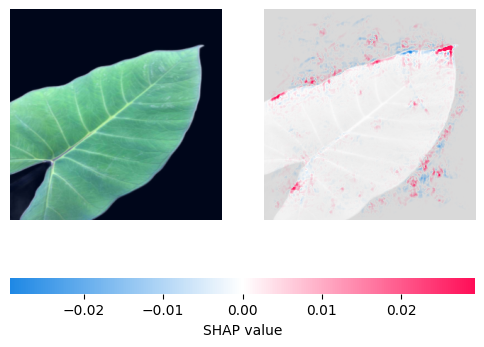

Image 7: The predicted class label is: H


<Figure size 640x480 with 0 Axes>

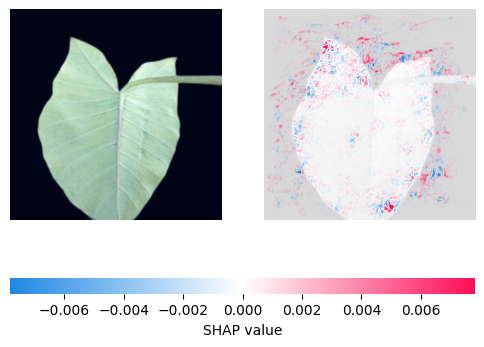

Image 8: The predicted class label is: M


<Figure size 640x480 with 0 Axes>

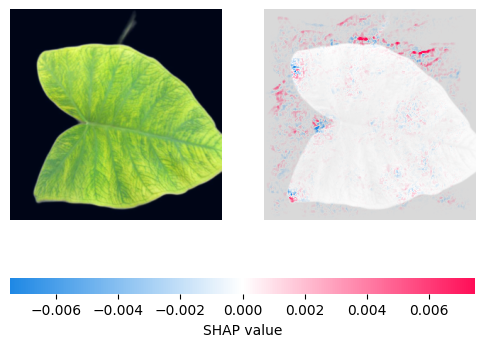

Image 9: The predicted class label is: M


<Figure size 640x480 with 0 Axes>

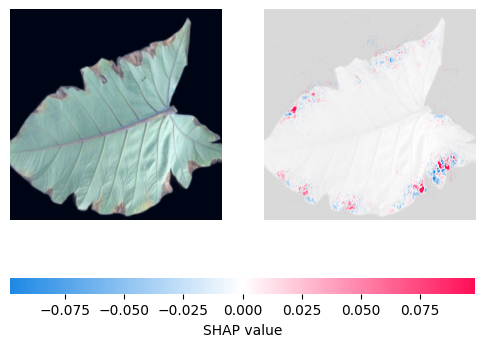

Image 10: The predicted class label is: L


<Figure size 640x480 with 0 Axes>

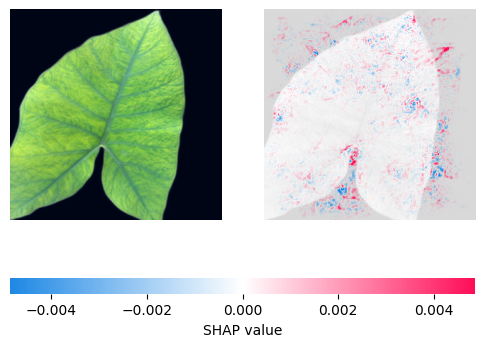

Image 11: The predicted class label is: M


<Figure size 640x480 with 0 Axes>

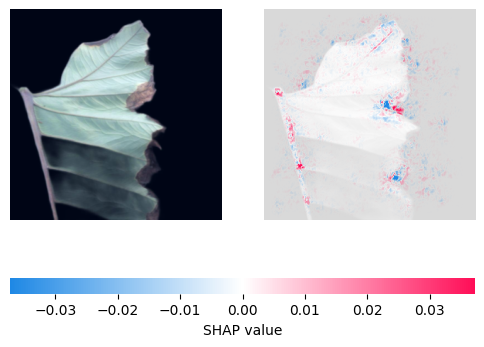

Image 12: The predicted class label is: L


<Figure size 640x480 with 0 Axes>

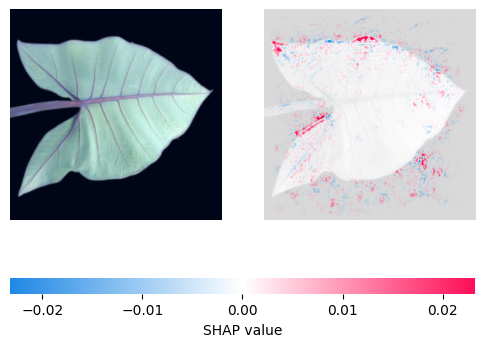

Image 13: The predicted class label is: H


<Figure size 640x480 with 0 Axes>

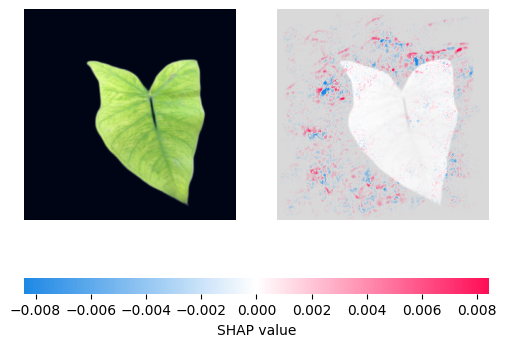

Image 14: The predicted class label is: M


<Figure size 640x480 with 0 Axes>

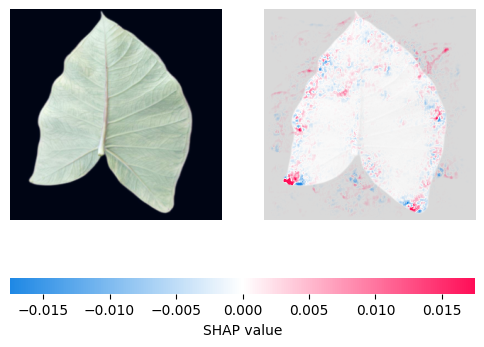

Image 15: The predicted class label is: M


<Figure size 640x480 with 0 Axes>

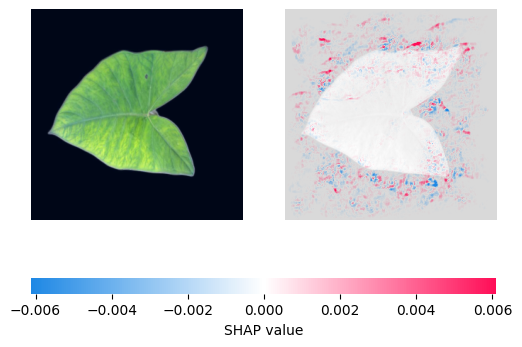

Image 16: The predicted class label is: M


<Figure size 640x480 with 0 Axes>

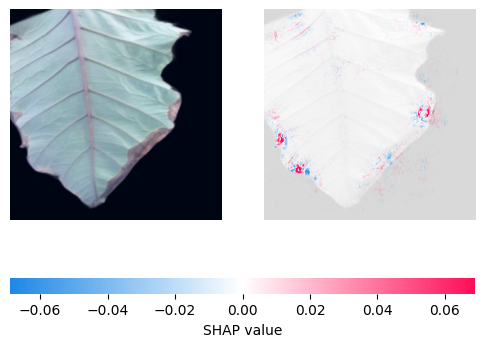

Image 17: The predicted class label is: L


<Figure size 640x480 with 0 Axes>

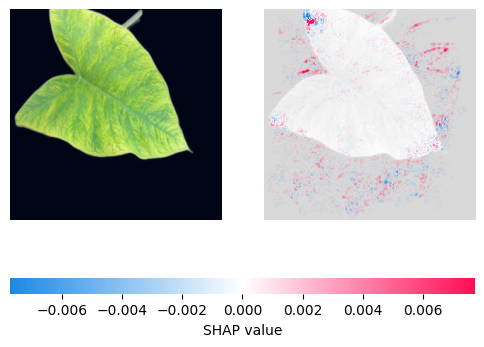

Image 18: The predicted class label is: M


<Figure size 640x480 with 0 Axes>

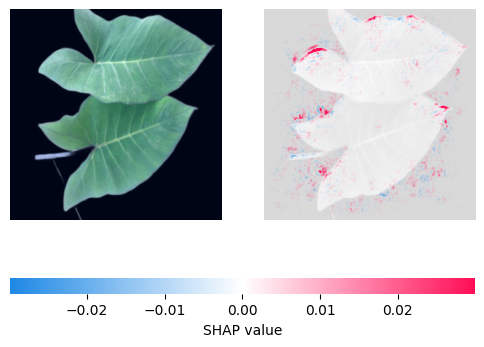

Image 19: The predicted class label is: H


<Figure size 640x480 with 0 Axes>

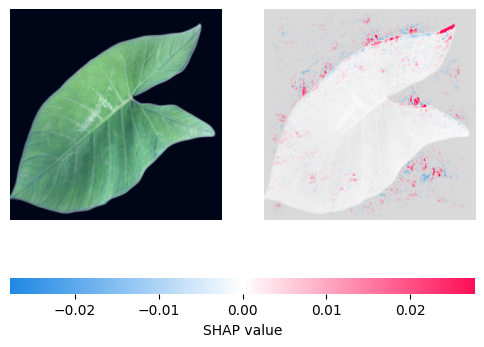

Image 20: The predicted class label is: H


<Figure size 640x480 with 0 Axes>

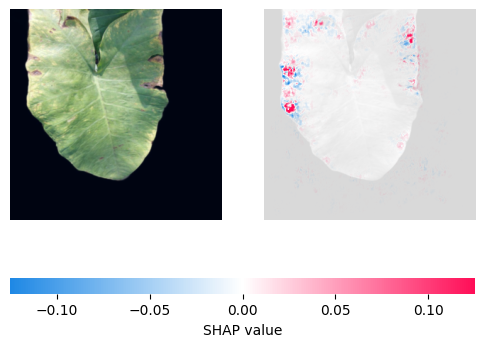

Image 21: The predicted class label is: L


<Figure size 640x480 with 0 Axes>

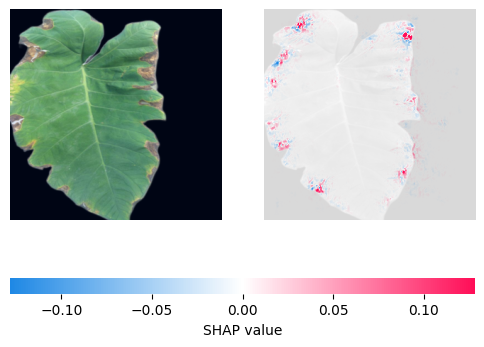

Image 22: The predicted class label is: L


<Figure size 640x480 with 0 Axes>

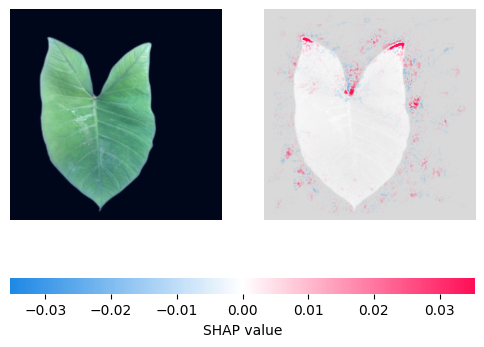

Image 23: The predicted class label is: H


<Figure size 640x480 with 0 Axes>

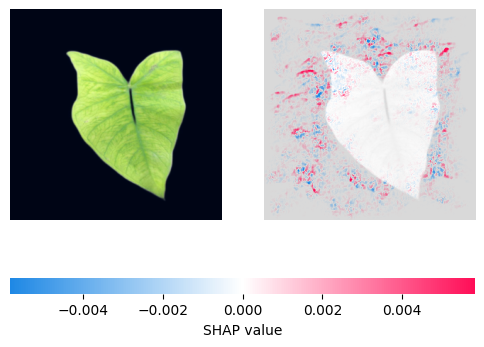

Image 24: The predicted class label is: M


<Figure size 640x480 with 0 Axes>

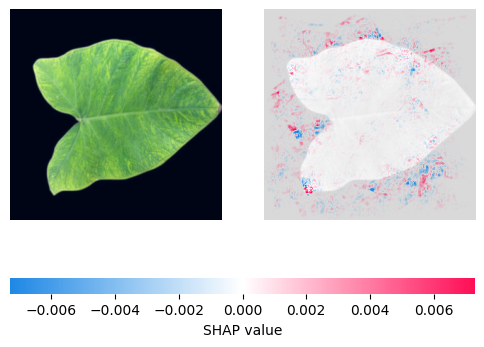

Image 25: The predicted class label is: M


<Figure size 640x480 with 0 Axes>

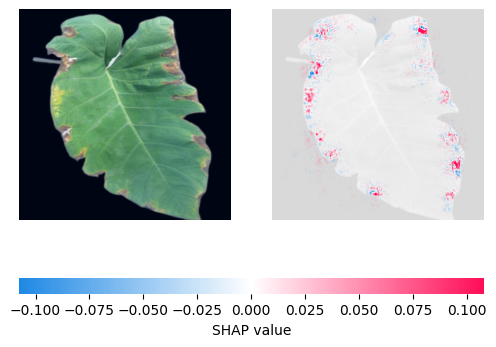

Image 26: The predicted class label is: L


<Figure size 640x480 with 0 Axes>

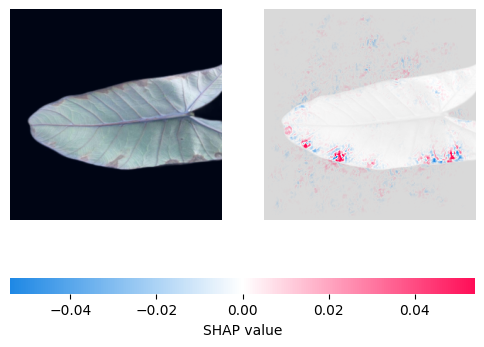

Image 27: The predicted class label is: L


<Figure size 640x480 with 0 Axes>

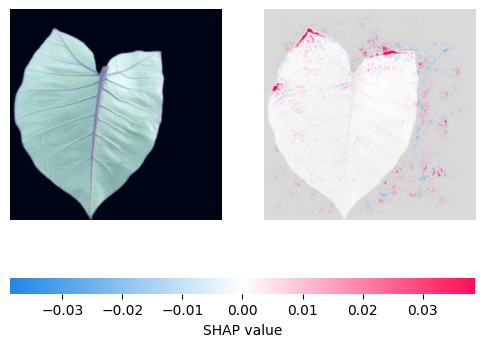

Image 28: The predicted class label is: H


<Figure size 640x480 with 0 Axes>

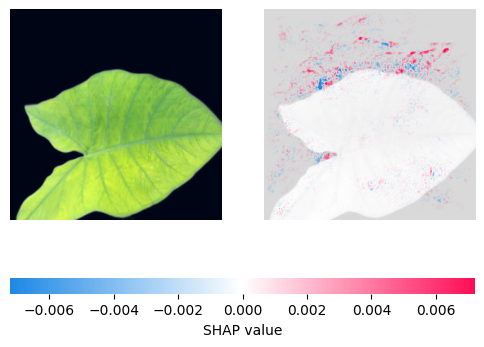

Image 29: The predicted class label is: M


<Figure size 640x480 with 0 Axes>

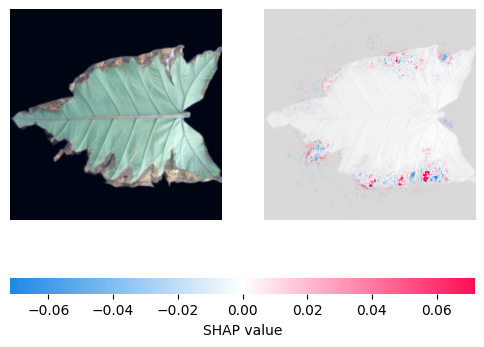

Image 30: The predicted class label is: L


<Figure size 640x480 with 0 Axes>

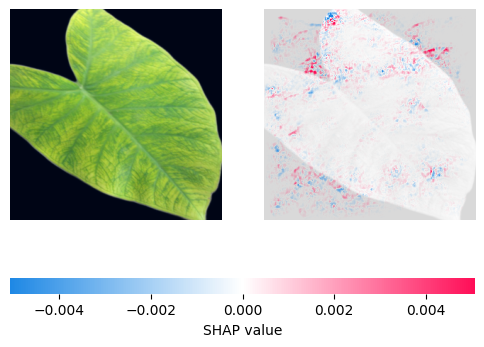

Image 31: The predicted class label is: M


<Figure size 640x480 with 0 Axes>

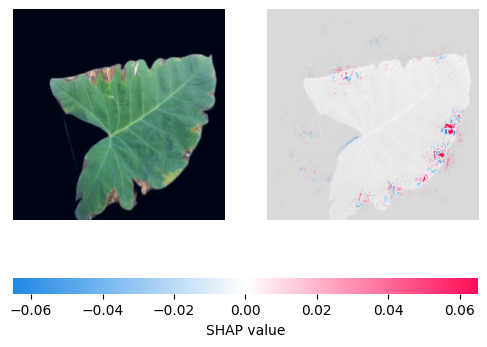

Image 32: The predicted class label is: L


RuntimeError: a Tensor with 0 elements cannot be converted to Scalar

In [111]:
import os
import matplotlib.pyplot as plt
import shap  # Assuming 'shap' has been imported correctly

# Replace this with the path to the directory where you want to save the images on your local system
save_dir = "/path/to/your/local/directory/SHAP_Explanations"
os.makedirs(save_dir, exist_ok=True)  # Create the save directory if it doesn't exist

for i in range(50):
    shap_values = e.shap_values(test_images[i:i+1])
    output = model(test_images[i:i+1])
    predicted_class = output.max(1)[1].item()
    shap_values_for_plotting = shap_values[0][predicted_class].transpose(0, 1, 2)


    # Normalize the image for visualization
    test_image_for_plotting = test_images[i].cpu().numpy().transpose(1, 2, 0)
    test_image_for_plotting = (test_image_for_plotting - test_image_for_plotting.min()) / (test_image_for_plotting.max() - test_image_for_plotting.min())

    # Display the image and its SHAP explanation
    plt.figure()
    shap.image_plot(shap_values_for_plotting[np.newaxis, :], test_image_for_plotting[np.newaxis, :])

    # Assume class_labels is a list or dictionary that contains the class labels
    print(f"Image {i+1}: The predicted class label is: {class_labels[predicted_class]}")

    # Save the figure with a filename that includes the image number and predicted class label
    filename = f"Image_{i+1}_Predicted_{class_labels[predicted_class]}.png"
    filepath = os.path.join(save_dir, filename)
    plt.savefig(filepath, bbox_inches='tight')
    plt.close()  # Close the plot to free up memory


<Figure size 640x480 with 0 Axes>

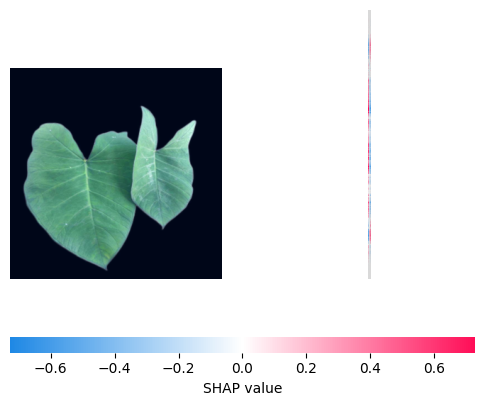

Imagen 1: La etiqueta de la clase predicha es: H


IndexError: index 1 is out of bounds for axis 0 with size 1

In [39]:
import matplotlib.pyplot as plt

# Asumiendo que 'dataloaders', 'model', 'device' están definidos previamente
# Asumiendo también que 'class_labels' está definido como mostraste

# Preparar el explicador SHAP con un conjunto de fondo
background, _ = next(iter(dataloaders['train']))
background = background.to(device)
e = shap.GradientExplainer(model, background,local_smoothing=0.1)

# Obtener imágenes de prueba y sus etiquetas
test_images, test_labels = next(iter(dataloaders['test']))
test_images = test_images.to(device)

# Procesar las primeras 10 imágenes
for i in range(30):
    shap_values = e.shap_values(test_images[i:i+1])
    output = model(test_images[i:i+1])
    predicted_class = output.max(1)[1].item()
    shap_values_for_plotting = shap_values[predicted_class][0].transpose(1, 2, 0)

    # Normalizar la imagen para la visualización
    test_image_for_plotting = test_images[i].cpu().numpy().transpose(1, 2, 0)
    test_image_for_plotting = (test_image_for_plotting - test_image_for_plotting.min()) / (test_image_for_plotting.max() - test_image_for_plotting.min())

    # Mostrar la imagen y su explicación SHAP
    plt.figure()
    shap.image_plot(shap_values_for_plotting[np.newaxis, :], test_image_for_plotting[np.newaxis, :])

    # Imprimir la etiqueta de la clase predicha
    print(f"Imagen {i+1}: La etiqueta de la clase predicha es: {class_labels[predicted_class]}")


The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.


ValueError: The parameter 'aux_logits' expected value True but got False instead.

In [ ]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Asumiendo que 'dataloaders', 'model', 'device', 'class_labels' están definidos previamente

# Preparar el explicador SHAP con un conjunto de fondo
background, _ = next(iter(dataloaders['train']))
background = background.to(device)
e = shap.GradientExplainer(model, background)

# Obtener imágenes de prueba y sus etiquetas
test_images, test_labels = next(iter(dataloaders['test']))
test_images = test_images.to(device)

# Procesar las primeras 3 imágenes (cambié a 3 para ser coherente con tu último ejemplo)
for i in range(20):
    shap_values = e.shap_values(test_images[i:i+1])
    output = model(test_images[i:i+1])
    predicted_class = output.max(1)[1].item()
    shap_values_for_plotting = shap_values[predicted_class][0].transpose(1, 2, 0)

    # Aplicar filtro gaussiano solo a los valores SHAP para suavizarlos
    shap_values_for_plotting = gaussian_filter(shap_values_for_plotting, sigma=2)  # Ajusta el sigma según necesidad para difuminar los valores SHAP

    # Normalizar la imagen para la visualización
    test_image_for_plotting = test_images[i].cpu().numpy().transpose(1, 2, 0)
    test_image_for_plotting = (test_image_for_plotting - test_image_for_plotting.min()) / (test_image_for_plotting.max() - test_image_for_plotting.min())

    # Mostrar la imagen y su explicación SHAP
    plt.figure()
    shap.image_plot(shap_values_for_plotting[np.newaxis, :], test_image_for_plotting[np.newaxis, :])

    # Imprimir la etiqueta de la clase predicha
    print(f"Imagen {i+1}: La etiqueta de la clase predicha es: {class_labels[predicted_class]}")


In [ ]:
!pip install umap-learn

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

# Inicializa una lista para almacenar los valores SHAP acumulados
shap_values_accumulated = []

# Procesar un conjunto de imágenes
for i in range(20):  # Ajusta según la capacidad de tu sistema
    # Calcula los valores SHAP para la imagen actual
    shap_values = e.shap_values(test_images[i:i+1])

    # Acumula los valores SHAP para una clase específica, por ejemplo, la clase predicha
    output = model(test_images[i:i+1])
    predicted_class = output.max(1)[1].item()
    # Asegurarse de que la conversión a NumPy se hace correctamente sin llamar a .cpu() en objetos que ya son arreglos de NumPy
    shap_values_accumulated.append(shap_values[predicted_class][0].reshape(-1))  # Directamente reshape y acumular

# Convertir la lista acumulada en un array de NumPy
shap_values_accumulated = np.array(shap_values_accumulated)
# Inicializar y ajustar PCA
pca = PCA(n_components=3)
shap_values_pca = pca.fit_transform(shap_values_accumulated)

# Visualizar los resultados de PCA
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Asignar un color a cada clase, puedes ajustar esto según tus etiquetas
colors = ['r', 'g', 'b']
for i in range(shap_values_pca.shape[0]):
    ax.scatter(shap_values_pca[i, 0], shap_values_pca[i, 1], shap_values_pca[i, 2], color=colors[predicted_class], alpha=0.5)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('PCA of SHAP Values')
plt.show()


In [ ]:
import umap
import numpy as np
import matplotlib.pyplot as plt

# Suponiendo que shap_values_accumulated ya contiene tus valores SHAP acumulados

# Inicializar y ajustar UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
shap_values_umap = reducer.fit_transform(shap_values_accumulated)

# Visualizar los resultados de UMAP en 2D
plt.figure(figsize=(10, 7))

# Asignar un color a cada clase, puedes ajustar esto según tus etiquetas
# Aquí, asumimos que 'predicted_class' es la clase predicha para la última imagen procesada
# Para una visualización más precisa, considera usar un arreglo con las clases reales o predichas para todas las imágenes procesadas
colors = ['r', 'g', 'b']
color_map = [colors[predicted_class] for i in range(len(shap_values_umap))]

plt.scatter(shap_values_umap[:, 0], shap_values_umap[:, 1], c=color_map, alpha=0.5)
plt.title('UMAP of SHAP Values')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar()
plt.show()


In [ ]:
shap_values_concatenated.shape

In [ ]:

import shap
import torch
import numpy as np
from sklearn.decomposition import PCA
# Asegúrate de que 'model' y 'dataloaders' estén definidos como se muestra en tu pregunta

# Obtener imágenes de prueba y sus etiquetas
test_images, test_labels = next(iter(dataloaders['test']))
test_images = test_images.to(device)

# Calcular los SHAP values
# Esto puede tomar tiempo dependiendo del tamaño de tu conjunto de datos de prueba y la complejidad del modelo
shap_values = e.shap_values(test_images)

# Concatenar los SHAP values para todas las clases, asumiendo un enfoque multiclase
shap_values_concatenated = np.concatenate([shap_values[i] for i in range(len(shap_values))], axis=1)

# Aplicar PCA para reducir la dimensionalidad
pca = PCA(n_components=2)  # Ajusta este valor según tus necesidades
shap_values_pca = pca.fit_transform(shap_values_concatenated.reshape(shap_values_concatenated.shape[0], -1))

# shap_values_pca ahora contiene tus SHAP values reducidos listos para ser utilizados en clustering


In [ ]:
shap_values_pca

In [ ]:
import os
import pandas as pd
from umap import UMAP

# Supongamos que estas funciones y variables ya están definidas
# embeddings, labels = extract_embeddings(dataloaders, model)


# Crear un DataFrame con los embeddings de UMAP
df_umap = pd.DataFrame(shap_values_pca, columns=['umap_x', 'umap_y'])
df_umap['label'] = test_labels  # Asumiendo que labels es un array de numpy

# Mapeo de etiquetas numéricas a nombres de subcarpetas
label_to_folder = {
    0: 'Healthy',
    1: 'Leaf Blight',
    2: 'Mosaic'
}

test_directory = '/content/descomprimido/Hojas/Test'
image_paths = []
used_images = set()  # Para rastrear las imágenes ya utilizadas

# Buscar imágenes correspondientes a cada etiqueta sin repetir
for index, row in df_umap.iterrows():
    label = row['label']
    folder_name = label_to_folder[label]
    subfolder = os.path.join(test_directory, folder_name)
    image_found = False
    for dirname, _, filenames in os.walk(subfolder):
        for filename in filenames:
            image_path = os.path.join(dirname, filename)
            if filename.endswith('.jpg') and image_path not in used_images:
                image_paths.append(image_path)
                used_images.add(image_path)
                image_found = True
                break
        if image_found:
            break

# Verificar si hemos encontrado una imagen para cada punto
if len(image_paths) != len(df_umap):
    print(f"Se encontraron {len(image_paths)} imágenes, pero hay {len(df_umap)} puntos UMAP.")
    # Manejar la situación como se prefiera, por ejemplo, asignando imágenes predeterminadas para los faltantes

# Añadir rutas de imágenes al DataFrame
df_umap['image_path'] = image_paths  # Asegurarse de que la longitud coincida


In [ ]:
test_labels

In [ ]:
df_umap

In [ ]:
import os
import pandas as pd
from umap import UMAP
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.transform import factor_cmap
from bokeh.palettes import Spectral10
from PIL import Image
import base64
from io import BytesIO
import numpy as np
from bokeh.plotting import figure, output_file, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.transform import factor_cmap
from bokeh.palettes import Spectral10
import base64
from io import BytesIO
import numpy as np
import pandas as pd
from umap import UMAP
from PIL import Image


# Aplicar UMAP

output_file("visualizacion_umap.html")

# Crear un DataFrame con los embeddings de UMAP y las etiquetas
df_umap = pd.DataFrame(shap_values_pca, columns=['umap_x', 'umap_y'])
df_umap['label'] = test_labels.cpu().numpy()  # Convertir el tensor a un array de NumPy correctamente  # Asumiendo que labels es un array de numpy

# Función para codificar imágenes en base64 para su uso en Bokeh
def img_to_base64(path):
    with open(path, 'rb') as f:
        return 'data:image/png;base64,' + base64.b64encode(f.read()).decode()

# Asumiendo que ya has mapeado las rutas de las imágenes en `image_paths` como se muestra arriba
df_umap['image_path'] = image_paths[:len(df_umap)]  # Asegurarse de que la longitud coincida
df_umap['image_base64'] = df_umap['image_path'].apply(img_to_base64)

# Preparar los datos para Bokeh
source = ColumnDataSource(data={
    'x': df_umap['umap_x'],
    'y': df_umap['umap_y'],
    'img': df_umap['image_base64'],
    'label': [str(x) for x in df_umap['label']]
})

# Configuración de la herramienta de Hover para mostrar imágenes
hover = HoverTool()
hover.tooltips = """
    <div>
        <div>
            <!-- Ajusta los valores de width y height según necesites -->
            <img src="@img" alt="" width="500" height="500" style="float: center; margin: 0px 15px 15px 0px;" border="2"></img>
        </div>
    </div>
"""

# Crear la figura de Bokeh
p = figure(width=300, height=300, tools=[hover, "pan", "wheel_zoom", "box_zoom", "reset"])
p.circle('x', 'y', size=5, source=source, color=factor_cmap('label', palette=Spectral10, factors=[str(x) for x in range(len(np.unique(test_labels.cpu().numpy())))]))

# Mostrar la figura en el notebook y guardarla en un archivo HTML
output_notebook()  # Para visualización en el notebook, comenta esta línea si no la necesitas
show(p)  # Esto generará la visualización y la guardará automáticamente en el archivo HTML especificado


In [ ]:
a